In [1]:
import ipynb.fs.full.functions as preprocessing

[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/user/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [2]:
from zipfile import ZipFile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%%time

data = pd.read_csv('categorized_data.csv')

# fix index
data.set_index('Unnamed: 0', inplace=True)
data.index.name = None

data.head()

CPU times: user 10.9 s, sys: 1.43 s, total: 12.3 s
Wall time: 13.1 s


,Complaint,Company,Product
84,I am a victim of identity theft. XXXX XXXX XXX...,"EQUIFAX, INC.","Credit reporting, credit repair services, or o..."
180,XXXX 2022 went just like any other XXXX of the...,Netspend Corporation,Bank account or service
369,In XXXX I fell behind on my mortgage payments ...,WELLS FARGO & COMPANY,Mortgage
549,I immigrated to the United States in XX/XX/XXX...,"EQUIFAX, INC.","Credit reporting, credit repair services, or o..."
583,ATTN Fraud Department : Remove fraudulent acco...,"EQUIFAX, INC.","Credit reporting, credit repair services, or o..."


Set a seed for reproducibility and get a sample of 100,000 records to build a proof of concept model.

In [4]:
# set a seed for reproducibility
seed = 839

In [5]:
# get 100,000 records to build a proof-of-concept model
sample = data.sample(100000, random_state=seed).copy()

In [6]:
sample.head()

,Complaint,Company,Product
3347590,XXXX XXXX XXXX XXXX : XXXX. XXXXXXXX XXXX XXXX...,"EQUIFAX, INC.","Credit reporting, credit repair services, or o..."
3273724,I have written you twice. Chase finds ways out...,JPMORGAN CHASE & CO.,Mortgage
543587,"I contacted Amex, who placed the inquiry, and ...",AMERICAN EXPRESS COMPANY,"Credit reporting, credit repair services, or o..."
1039197,"In XXXX of 2018, I started getting calls from ...","CREDIT BUREAU OF NAPA COUNTY, INC.",Debt collection
1935540,On ( XX/XX/2022 ) I sent a letter regarding in...,"EQUIFAX, INC.","Credit reporting, credit repair services, or o..."


Split the data into train, test and validation sets, preprocess the complaint text, and fit a baseline model to the entire training set.

In [7]:
from sklearn.model_selection import train_test_split

X = sample.drop(['Product'], axis=1).copy()
y = sample.Product.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [8]:
# split training data into training and validation data

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.25,
                                                  random_state=seed)

In [9]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(60000, 2)
(20000, 2)
(20000, 2)


In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
val_labels = le.transform(y_val)

print(train_labels.shape)
print(val_labels.shape)
train_labels

(60000,)
(20000,)


array([3, 3, 4, ..., 3, 4, 3])

In [11]:
X_train.head(2)

,Complaint,Company
364212,"This is XXXX XXXX, who is submitting this CFPB...","EQUIFAX, INC."
2207116,I am disputing a couple of inaccurate items on...,"EQUIFAX, INC."


Below, the complaints are mapped to a list of tokens, which are then mapped to a list of tokens with redacted material removed, and finally, those "clean tokens" are mapped to a list of lemmas for that particular complaint.

The functions for performing this preprocessing are stored in a separate notebook (functions.ipynb.) If you are running this notebook in your own environment, make sure that you have the package "ipynb" installed. (It should have thrown an error at the top of this notebook if it's not already installed.)

In [12]:
X_train['tokens'] = X_train.Complaint.map(preprocessing.get_tokens)

X_train['clean_tokens'] = preprocessing.remove_redactions(X_train['tokens'])

X_train['lemmas'] = preprocessing.lemmatize(X_train['clean_tokens'])

X_train.head(2)

,Complaint,Company,tokens,clean_tokens,lemmas
364212,"This is XXXX XXXX, who is submitting this CFPB...","EQUIFAX, INC.","[xxxx, xxxx, submitting, cfpb, complaint, info...","[submitting, cfpb, complaint, inform, third, p...","[submit, cfpb, complaint, inform, third, party..."
2207116,I am disputing a couple of inaccurate items on...,"EQUIFAX, INC.","[disputing, couple, inaccurate, items, credit,...","[disputing, couple, inaccurate, items, credit,...","[dispute, couple, inaccurate, item, credit, re..."


Let's repeat the above preprocessing work for the validation set.

In [14]:
X_val['tokens'] = X_val.Complaint.map(preprocessing.get_tokens)

X_val['clean_tokens'] = preprocessing.remove_redactions(X_val['tokens'])

X_val['lemmas'] = preprocessing.lemmatize(X_val['clean_tokens'])

,submit,cfpb,complaint,inform,third,party,involved,process,send,letter,...,verififcation,clarifiy,affliate,refuting,penatgon,attatching,conatact,cherrington,candy,acquantained
3277011,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2844354,0.095702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Preprocessing the training and validation data takes a while, so let's store them on disk.

In [15]:
with open('train-test-split/train', 'w') as f:
    X_train.to_csv(f)
    
with open('train-test-split/val', 'w') as f:
    X_val.to_csv(f)

Next, the lemmas for each complaint are vectorized using term frequency - inverse document frequency.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer()

vectorized_words = pd.DataFrame(
    tfidf_vec.fit_transform(X_train['lemmas'].map(lambda x: ' '.join(x))).todense(),
    columns=list(tfidf_vec.vocabulary_.keys()),
    index=X_train.index)

vectorized_words.head(2)

,submit,cfpb,complaint,inform,third,party,involved,process,send,letter,...,verififcation,clarifiy,affliate,refuting,penatgon,attatching,conatact,cherrington,candy,acquantained
364212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2207116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Do the same to the validation data, but don't re-fit the vectorizer.

In [ ]:
val_vectorized_words = pd.DataFrame(
    tfidf_vec.transform(X_val['lemmas'].map(lambda x: ' '.join(x))).todense(),
    columns=list(tfidf_vec.vocabulary_.keys()),
    index=X_val.index)

val_vectorized_words.head(2)

Finally, a baseline model is constructed using Naive Bayes. I'm going to store each model as well as the train and validation scores for the model, in the dictionary "model_scores".

In [18]:
from sklearn.naive_bayes import MultinomialNB

baseline = MultinomialNB()
baseline.fit(vectorized_words, train_labels)

from sklearn.base import clone

model_scores = {'baseline': {
    'model': clone(baseline),
    'train': baseline.score(vectorized_words, train_labels),
    'test': baseline.score(val_vectorized_words, val_labels)}
               }

model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991}}

There is certainly room for improvement, but this is not a terrible score to start. (A classifier which picks the majority class would have an accuracy of ~51% for this training set.)

Let's try to understand where this model goes wrong, and see if it suggests any particular avenues for improvement.

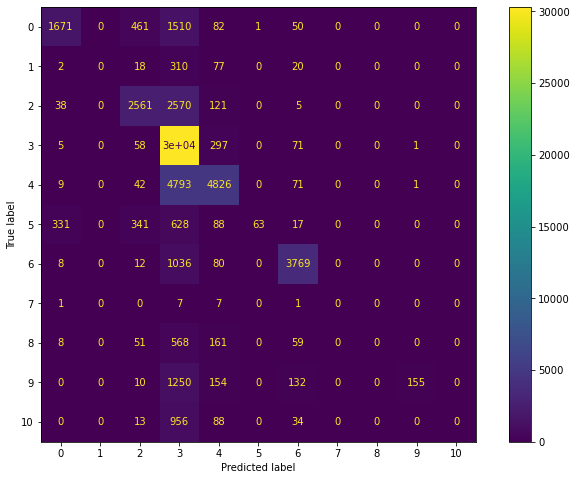

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(12, 8))

ConfusionMatrixDisplay(confusion_matrix(train_labels, baseline.predict(vectorized_words)))\
.plot(ax=ax);

It is difficult to interpret a raw count confusion matrix because the classes are heavily imbalanced. Normalize along each row to improve interpretability.

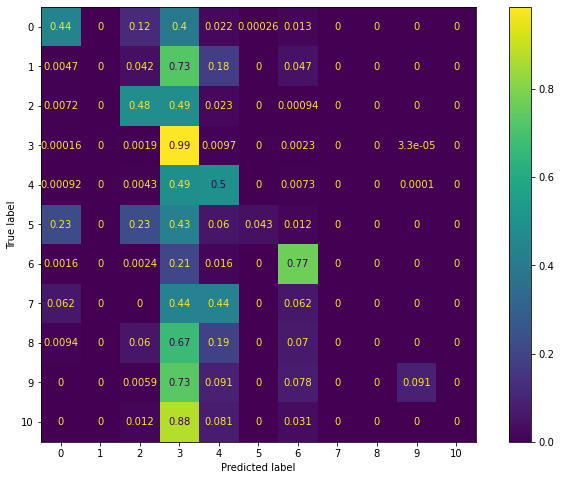

In [42]:
fig, ax = plt.subplots(figsize=(12, 8))

ConfusionMatrixDisplay(confusion_matrix(train_labels,
                                        baseline.predict(vectorized_words),
                                        normalize='true')).plot(ax=ax);

Unsurprisingly, the heavy-majority class has 99% accuracy while most other classes struggle.

Here is the distribution of product categories in the training set:

In [44]:
y_train.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    30733
Debt collection                                                                  9742
Credit card or prepaid card                                                      5295
Mortgage                                                                         4905
Bank account or service                                                          3775
Student loan                                                                     1701
Money transfer, virtual currency, or money service                               1468
Vehicle loan or lease                                                            1091
Payday loan, title loan, or personal loan                                         847
Consumer Loan                                                                     427
Other financial service                                                            16
Name: Product, dtype: int64

The ability of the baseline model to correctly predict the class of a complaint is (loosely) correlated to the size of that class in the training data.

View the top words in each category:

The cell below concatenates the product information with the lemmas for the complaint, then creates a list of all lemmas in a particular product category and stores this in a dictionary (key = product.)

In [20]:
train = pd.concat([X_train, y_train], axis=1)

from collections import defaultdict
product_lemmas = defaultdict()

for product in np.unique(train.Product):
    product_lemmas[product] = []
    for row in train.loc[train.Product == product, 'lemmas']:
        product_lemmas[product].extend(row)

Next, we iterate over each product and get the counts for the top 5 words in that product category using nltk's FreqDist function. Create a plot for each product.

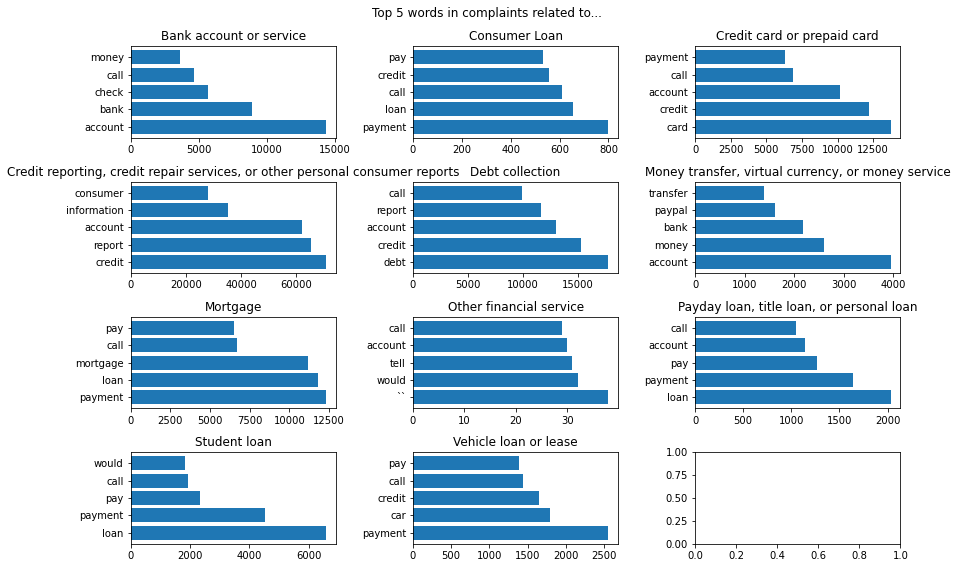

In [21]:
from nltk import FreqDist

n = 5

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 8))

for i, product in enumerate(np.unique(train.Product)):
    fdist = FreqDist(product_lemmas[product])
    labels = [x[0] for x in fdist.most_common(n)]
    counts = [x[1] for x in fdist.most_common(n)]
    
    current_ax = ax[i // 3][i % 3]
    plt.sca(current_ax)
    plt.barh(y=np.linspace(1,n,n), width=counts)
    current_ax.set_yticks(np.linspace(1,n,n))
    current_ax.set_yticklabels(labels)
    fig.suptitle(f'Top {n} words in complaints related to...')
    current_ax.set_title(product)
    
fig.tight_layout();

Based on these plots, I realize that forcing the model to ignore words which occur in every category (or even most categories) could improve the model's performance.

Including bigrams could also help the model to distinguish between product categories (ex: "credit card" vs. "credit report".)

In [22]:
tfidf_vec2 = TfidfVectorizer(min_df=0.05, max_df=0.95)

vectorized_words2 = pd.DataFrame(
    tfidf_vec2.fit_transform(X_train['lemmas'].map(lambda x: ' '.join(x))).todense(),
    columns=list(tfidf_vec2.vocabulary_.keys()),
    index=X_train.index)

vectorized_words2.head(2)

,submit,complaint,inform,third,party,process,send,letter,equifax,credit,...,wrong,way,purchase,victim,stop,statement,score,transfer,online,already
364212,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.081658,0.0,0.157253,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2207116,0.0,0.0,0.0,0.062139,0.0,0.0,0.0,0.000000,0.0,0.054401,...,0.0,0.0,0.061215,0.0,0.0,0.043737,0.0,0.0,0.0,0.194373


In [23]:
val_vectorized_words2 = pd.DataFrame(
    tfidf_vec2.transform(X_val['lemmas'].map(lambda x: ' '.join(x))).todense(),
    columns=list(tfidf_vec2.vocabulary_.keys()),
    index=X_val.index)

val_vectorized_words2.head(2)

,submit,complaint,inform,third,party,process,send,letter,equifax,credit,...,wrong,way,purchase,victim,stop,statement,score,transfer,online,already
3277011,0.000000,0.31106,0.376439,0.0,0.0,0.0,0.186292,0.156645,0.0,0.15083,...,0.0,0.0,0.0,0.13876,0.000000,0.0,0.143111,0.0,0.0,0.0
2844354,0.216687,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.327832,0.0,0.000000,0.0,0.0,0.0


In [24]:
min_max_df = MultinomialNB()
min_max_df.fit(vectorized_words2, train_labels)

model_scores['min_max_df'] = {
    'model': clone(min_max_df),
    'train': min_max_df.score(vectorized_words2, train_labels),
    'test': min_max_df.score(val_vectorized_words2, val_labels)
}

model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935}}

Ignoring words which have extremely high or extremely low document frequency was helpful - it increased the accuracy of our model on the validation set by ~4%. The model is also less overfit.

Try adding bigrams.

In [25]:
tfidf_vec_w_bigrams = TfidfVectorizer(min_df=0.05, max_df=0.95, ngram_range=(1,2))

vectorized_words3 = pd.DataFrame(
    tfidf_vec_w_bigrams.fit_transform(X_train['lemmas'].map(lambda x: ' '.join(x))).todense(),
    columns=list(tfidf_vec_w_bigrams.vocabulary_.keys()),
    index=X_train.index)

val_vectorized_words3 = pd.DataFrame(
    tfidf_vec_w_bigrams.transform(X_val['lemmas'].map(lambda x: ' '.join(x))).todense(),
    columns=list(tfidf_vec_w_bigrams.vocabulary_.keys()),
    index=X_val.index)

In [26]:
include_bigrams = MultinomialNB()
include_bigrams.fit(vectorized_words3, train_labels)

model_scores['include_bigrams'] = {
    'model': clone(include_bigrams),
    'train': include_bigrams.score(vectorized_words3, train_labels),
    'test': include_bigrams.score(val_vectorized_words3, val_labels)
}

model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445}}

This is the best result yet, but we are still landing at a validation accuracy of 74.45%.

Try undersampling:

Get a random undersample of the majority class, and keep all data on other classes.

In [52]:
majority_class='Credit reporting, credit repair services, or other personal consumer reports'

# get indices for undersampled
majority_indices = train.loc[train.Product==majority_class].sample(10000,
                                                                   random_state=seed).index
minority_indices = train.loc[train.Product!=majority_class].index
undersampled_indices = list(set(majority_indices).union(set(minority_indices)))

undersampled_X_train = X_train.loc[undersampled_indices]

undersampled_train_labels = le.fit_transform(y_train[undersampled_indices])

Vectorize this data.

In [47]:
vectorized_words4 = pd.DataFrame(
    tfidf_vec_w_bigrams.fit_transform(
        undersampled_X_train['lemmas'].map(lambda x: ' '.join(x))).todense(),
        columns=list(tfidf_vec_w_bigrams.vocabulary_.keys()),
        index=undersampled_X_train.index)

val_vectorized_words4 = pd.DataFrame(
    tfidf_vec_w_bigrams.transform(X_val['lemmas'].map(lambda x: ' '.join(x))).todense(),
    columns=list(tfidf_vec_w_bigrams.vocabulary_.keys()),
    index=X_val.index)

Fit a model to vectorized, undersampled data.

In [54]:
undersampled = MultinomialNB()
undersampled.fit(vectorized_words4, undersampled_train_labels)

model_scores['undersampled'] = {
    'model': clone(undersampled),
    'train': undersampled.score(vectorized_words4, undersampled_train_labels),
    'test': undersampled.score(val_vectorized_words4, val_labels)
}

model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445},
 'undersampled': {'model': MultinomialNB(),
  'train': 0.6756054702421881,
  'test': 0.7163}}

Undersampling produced worse results.

Try a different type of classifier.

In [55]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=seed)
rf.fit(vectorized_words3, train_labels)

model_scores['rf'] = {
    'model': clone(rf),
    'train': rf.score(vectorized_words3, train_labels),
    'test': rf.score(val_vectorized_words3, val_labels)
}

model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445},
 'undersampled': {'model': MultinomialNB(),
  'train': 0.6756054702421881,
  'test': 0.7163},
 'rf': {'model': RandomForestClassifier(random_state=839),
  'train': 0.9970333333333333,
  'test': 0.791}}

The scores we obtained with the random forest classifier are our best yet, though the model is clearly overfit to the training data.

The current random forest model has trees with depth close to 140. Each tree has between 10,000 and 12,000 leaves:

In [61]:
# checking depth and number of leaves for each tree in "baseline" random forest
np.mean([(estimator.get_depth(), estimator.get_n_leaves()) for estimator in rf.estimators_],
       axis=0)

array([  144.55, 10657.02])

Tune some parameters to encourage the model not to overfit.

In [62]:
from sklearn.model_selection import GridSearchCV

grid = {'n_estimators': [10, 100, 200],
        'max_depth': [1, 50, 100, 150],
        'max_leaf_nodes': [500, 10000],
        'random_state': [seed]}

rf2 = RandomForestClassifier()

grid_search = GridSearchCV(rf2, grid, scoring='accuracy', return_train_score=True)

grid_search.fit(vectorized_words3, train_labels)

model_scores['rf_grid_search1'] = {
    'model': clone(grid_search.best_estimator_),
    'train': grid_search.cv_results_['mean_train_score'][grid_search.best_index_],
    'test': grid_search.best_score_
}

model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445},
 'undersampled': {'model': MultinomialNB(),
  'train': 0.6756054702421881,
  'test': 0.7163},
 'rf': {'model': RandomForestClassifier(random_state=839),
  'train': 0.9970333333333333,
  'test': 0.791},
 'rf_grid_search1': {'model': RandomForestClassifier(max_depth=100, max_leaf_nodes=10000, n_estimators=200,
                         random_state=839),
  'train': 0.9971916666666667,
  'test': 0.7918333333333333}}

Our best random forest classifier from the grid search has a similar accuracy to the original random forest, and in fact, it has close to the same parameters, except that the number of estimators is increased. (The max depth is decreased also.)

Before we move on, let's see if we can improve the random forest classifier by balancing the class weights.

In [63]:
rf2 = RandomForestClassifier(class_weight='balanced', random_state=seed)

rf2.fit(vectorized_words3, train_labels)

model_scores['rf2'] = {
    'model': clone(rf2),
    'train': rf2.score(vectorized_words3, train_labels),
    'test': rf2.score(val_vectorized_words3, val_labels)
}

model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445},
 'undersampled': {'model': MultinomialNB(),
  'train': 0.6756054702421881,
  'test': 0.7163},
 'rf': {'model': RandomForestClassifier(random_state=839),
  'train': 0.9970333333333333,
  'test': 0.791},
 'rf_grid_search1': {'model': RandomForestClassifier(max_depth=100, max_leaf_nodes=10000, n_estimators=200,
                         random_state=839),
  'train': 0.9971916666666667,
  'test': 0.7918333333333333},
 'rf2': {'model': RandomForestClassifier(class_weight='balanced', random_state=839),
  'train': 0.9958833333333333,
  'test': 0.78685}}

Balancing the class weights actually decreases the performance of the model.

I doubt that we can do better with a logistic regression model, but let's fit one to see if we can deliver decent results with a simpler, less memory intensive type of model.

In [64]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=seed)
logreg.fit(vectorized_words3, train_labels)

model_scores['logreg'] = {
    'model': clone(logreg),
    'train': logreg.score(vectorized_words3, train_labels),
    'test': logreg.score(val_vectorized_words3, val_labels)
}

model_scores

/Users/user/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445},
 'undersampled': {'model': MultinomialNB(),
  'train': 0.6756054702421881,
  'test': 0.7163},
 'rf': {'model': RandomForestClassifier(random_state=839),
  'train': 0.9970333333333333,
  'test': 0.791},
 'rf_grid_search1': {'model': RandomForestClassifier(max_depth=100, max_leaf_nodes=10000, n_estimators=200,
                         random_state=839),
  'train': 0.9971916666666667,
  'test': 0.7918333333333333},
 'rf2': {'model': RandomForestClassifier(class_weight='balanced', random_state=839),
  'train': 0.9958833333333333,
  'test': 0.78685},
 'logreg': {'model': LogisticRegression(random_state=839),
  'train': 0.7954666666666667,
  'test': 0.7901}}

A vanilla logistic regression performed almost as well as the best random forest so far, and it didn't even converge (nor is it overfit to the training data.)

Try decreasing the regularization strength to see if this caused the failure to converge (and possibly also prevented overfitting.)

In [65]:
logreg2 = LogisticRegression(C=10000, random_state=seed)

logreg2.fit(vectorized_words3, train_labels)

model_scores['logreg2'] = {
    'model': clone(logreg2),
    'train': logreg2.score(vectorized_words3, train_labels),
    'test': logreg2.score(val_vectorized_words3, val_labels)
}

model_scores

/Users/user/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445},
 'undersampled': {'model': MultinomialNB(),
  'train': 0.6756054702421881,
  'test': 0.7163},
 'rf': {'model': RandomForestClassifier(random_state=839),
  'train': 0.9970333333333333,
  'test': 0.791},
 'rf_grid_search1': {'model': RandomForestClassifier(max_depth=100, max_leaf_nodes=10000, n_estimators=200,
                         random_state=839),
  'train': 0.9971916666666667,
  'test': 0.7918333333333333},
 'rf2': {'model': RandomForestClassifier(class_weight='balanced', random_state=839),
  'train': 0.9958833333333333,
  'test': 0.78685},
 'logreg': {'model': LogisticRegression(random_state=839),
  'train': 0.7954666666666667,
  'test': 0.7901},
 'logreg2': {'model': LogisticRegression(C=10000, random_state=839),
  'trai

Interestingly, increasing the regularization strength didn't fix the convergence problem.

Increase the maximum number of iterations performed.

In [66]:
logreg3 = LogisticRegression(max_iter=10000, random_state=seed)

logreg3.fit(vectorized_words3, train_labels)

model_scores['logreg3'] = {
    'model': clone(logreg3),
    'train': logreg3.score(vectorized_words3, train_labels),
    'test': logreg3.score(val_vectorized_words3, val_labels)
}

model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445},
 'undersampled': {'model': MultinomialNB(),
  'train': 0.6756054702421881,
  'test': 0.7163},
 'rf': {'model': RandomForestClassifier(random_state=839),
  'train': 0.9970333333333333,
  'test': 0.791},
 'rf_grid_search1': {'model': RandomForestClassifier(max_depth=100, max_leaf_nodes=10000, n_estimators=200,
                         random_state=839),
  'train': 0.9971916666666667,
  'test': 0.7918333333333333},
 'rf2': {'model': RandomForestClassifier(class_weight='balanced', random_state=839),
  'train': 0.9958833333333333,
  'test': 0.78685},
 'logreg': {'model': LogisticRegression(random_state=839),
  'train': 0.7954666666666667,
  'test': 0.7901},
 'logreg2': {'model': LogisticRegression(C=10000, random_state=839),
  'trai

Increasing the number of iterations fixes the lack of convergence problem, and it technically improves performance on the test set, but not by much.

Try different strengths of regularization:

In [79]:
grid = {'C': [0.01, 0.1, 1],
        'max_iter': [10000],
        'random_state': [seed]}

logreg4 = LogisticRegression()
grid_search = GridSearchCV(logreg4, grid, scoring='accuracy', return_train_score=True, cv=2)
grid_search.fit(vectorized_words3, train_labels)

model_scores['logreg_grid_search1'] = {
    'model': clone(grid_search.best_estimator_),
    'train': grid_search.cv_results_['mean_train_score'][grid_search.best_index_],
    'test': grid_search.best_score_
}

model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445},
 'undersampled': {'model': MultinomialNB(),
  'train': 0.6756054702421881,
  'test': 0.7163},
 'rf': {'model': RandomForestClassifier(random_state=839),
  'train': 0.9970333333333333,
  'test': 0.791},
 'rf_grid_search1': {'model': RandomForestClassifier(max_depth=100, max_leaf_nodes=10000, n_estimators=200,
                         random_state=839),
  'train': 0.9971916666666667,
  'test': 0.7918333333333333},
 'rf2': {'model': RandomForestClassifier(class_weight='balanced', random_state=839),
  'train': 0.9958833333333333,
  'test': 0.78685},
 'logreg': {'model': LogisticRegression(random_state=839),
  'train': 0.7954666666666667,
  'test': 0.7901},
 'logreg2': {'model': LogisticRegression(C=10000, random_state=839),
  'trai

In [80]:
grid = {'C': [1, 10, 100, 1000],
        'max_iter': [10000],
        'random_state': [seed]}

logreg5 = LogisticRegression()
grid_search = GridSearchCV(logreg5, grid, scoring='accuracy', return_train_score=True, cv=2)
grid_search.fit(vectorized_words3, train_labels)

model_scores['logreg_grid_search2'] = {
    'model': clone(grid_search.best_estimator_),
    'train': grid_search.cv_results_['mean_train_score'][grid_search.best_index_],
    'test': grid_search.best_score_
}

model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445},
 'undersampled': {'model': MultinomialNB(),
  'train': 0.6756054702421881,
  'test': 0.7163},
 'rf': {'model': RandomForestClassifier(random_state=839),
  'train': 0.9970333333333333,
  'test': 0.791},
 'rf_grid_search1': {'model': RandomForestClassifier(max_depth=100, max_leaf_nodes=10000, n_estimators=200,
                         random_state=839),
  'train': 0.9971916666666667,
  'test': 0.7918333333333333},
 'rf2': {'model': RandomForestClassifier(class_weight='balanced', random_state=839),
  'train': 0.9958833333333333,
  'test': 0.78685},
 'logreg': {'model': LogisticRegression(random_state=839),
  'train': 0.7954666666666667,
  'test': 0.7901},
 'logreg2': {'model': LogisticRegression(C=10000, random_state=839),
  'trai

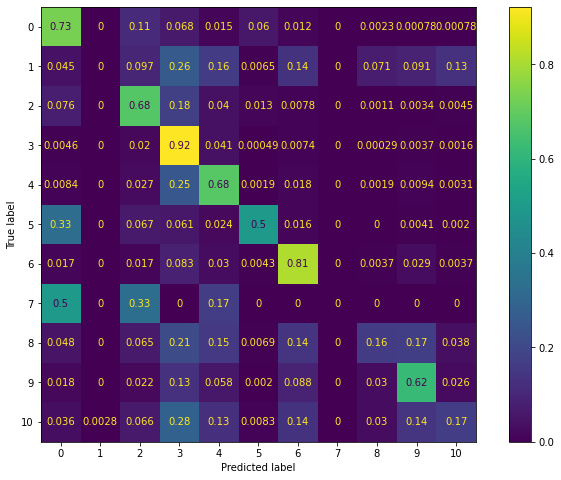

In [82]:
fig, ax = plt.subplots(figsize=(12, 8))

ConfusionMatrixDisplay(confusion_matrix(val_labels,
                                        grid_search.best_estimator_.predict(
                                            val_vectorized_words3),
                                        normalize='true')).plot(ax=ax);

Try performing PCA before fitting the model.

First, find the best model so far:

In [102]:
results = pd.DataFrame({'model': list(model_scores.keys()),
                        'train': [model['train'] for model in list(model_scores.values())],
                        'test': [model['test'] for model in list(model_scores.values())]}
            )

In [104]:
results.loc[results.test == results.test.max()]

,model,train,test
5,rf_grid_search1,0.997192,0.791833


In [106]:
best_model_so_far = model_scores['rf_grid_search1']['model']

# Next Steps:

- Try Bayesian Optimization for hyperparameter turning with SciKit Optimization (with best model so far.) [Tutorial here](https://machinelearningmastery.com/scikit-optimize-for-hyperparameter-tuning-in-machine-learning/)
- Try PCA or some other dimensionality reduction technique (with best model so far.)

Tips from [Stack Overflow](https://stackoverflow.com/questions/20463281/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn) on hyperparameter tuning for random forests:

I would agree with @Falcon w.r.t. the dataset size. It's likely that the main problem is the small size of the dataset. If possible, the best thing you can do is get more data, the more data (generally) the less likely it is to overfit, as random patterns that appear predictive start to get drowned out as the dataset size increases.

That said, I would look at the following params:

n_estimators: @Falcon is wrong, in general the more trees the less likely the algorithm is to overfit. So try increasing this. The lower this number, the closer the model is to a decision tree, with a restricted feature set.

max_features: try reducing this number (try 30-50% of the number of features). This determines how many features each tree is randomly assigned. The smaller, the less likely to overfit, but too small will start to introduce under fitting.

max_depth: Experiment with this. This will reduce the complexity of the learned models, lowering over fitting risk. Try starting small, say 5-10, and increasing you get the best result.

min_samples_leaf: Try setting this to values greater than one. This has a similar effect to the max_depth parameter, it means the branch will stop splitting once the leaves have that number of samples each.

Note when doing this work to be scientific. Use 3 datasets, a training set, a separate 'development' dataset to tweak your parameters, and a test set that tests the final model, with the optimal parameters. Only change one parameter at a time and evaluate the result. Or experiment with the sklearn gridsearch algorithm to search across these parameters all at once.

In [109]:
from sklearn.decomposition import PCA

scores = []

for n in range(1, len(vectorized_words3)):
    pca = PCA(n_components=n, random_state=seed)
    
    transformed = pca.fit_transform(vectorized_words3)
    
    best_model_so_far.fit(transformed, train_labels)
    
    score = best_model_so_far.score(pca.transform(val_vectorized_words3), val_labels)
    
    scores.append(score)
    
    if score >= 0.8:
        break
    else:
        continue

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()

plt.plot(x=list(np.range(1, n)), y=scores)

ax.set(title='Accuracy by Number of Components Used in PCA',
       ylabel='Validation Accuracy',
       xlabel='Number of Components Kept');